In [1]:
from lib.controller import Controller
from lib.automation import FileDetector
from lib.file.TIF import TIFArrayFile
from lib.analysis.ROI_identification import *
import time
import os
from lib.utilities import *


In [2]:
data_dir = "C:/Users/jjudge3/Desktop/Data/06-21-22/"
camera_program = 4

slice_target = 2
rec_target = 3

1-1.tif
1-1e.tif
1-1f.tif
2-1.tif
2-1e.tif
2-1f.tif
3-1.tif
3-1e.tif
3-1f.tif


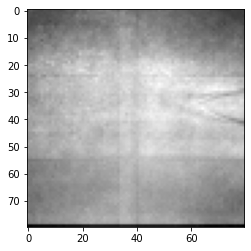

In [3]:
# read in 8-bit single TIF images to array, apply same cropping/binning
dic_dir = data_dir + "dic/"
single_images = {}

cam_settings = CameraSettings().get_program_settings(camera_program)
binning = int(cam_settings['height'] / 80)

for filename in os.listdir(dic_dir):
    print(filename)
    if filename.endswith(".tif"):
                
        tif = TIFArrayFile(filename, dic_dir, cam_settings, binning,
                          show_image=(str(slice_target) in filename and
                                      'e' in filename))
        
        img = tif.get_data()
        meta = tif.get_meta()
        slic = meta['slice_number']
        loc = meta['location_number']
        img_type = meta['img_type']
        
        if slic not in single_images:
            single_images[slic] = {}
        if loc not in single_images[slic]:
            single_images[slic][loc] = {}
        
        single_images[slic][loc][img_type] = img



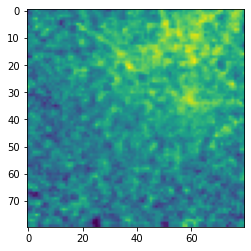

In [4]:
# read in non-normalized maps exported from PhotoZ: 
#  pre-stim SNR, stim SNR, and stim MaxAmp (DAT files)
dat_dir = data_dir + "converted_zda/"
for filename in os.listdir(dat_dir):
    if filename.endswith(".dat"):
        map_type = filename[:3]
        name_parse = filename.split('.')[0][-8:]
        slic, loc, rec = [int(x) for x in name_parse.split('_')]
        if slic not in single_images:
            single_images[slic] = {}
        if loc not in single_images[slic]:
            single_images[slic][loc] = {}
        if map_type not in single_images[slic][loc]:
            single_images[slic][loc][map_type] = {}
        dat = np.loadtxt(dat_dir + filename,
                         delimiter='\t',
                         usecols=(1,))
        width = int(np.sqrt(dat.shape[0]))
        dat = dat.reshape((width, width))
        if map_type == "SNR" and slic == slice_target and rec == rec_target:
            plt.imshow(dat)
        single_images[slic][loc][map_type][rec] = dat
        

In [5]:
# record stim amplitudes manually
stims = {}
single_images[1][1]['stims'] = [100, 100, 100, 80, 80, 60, 60, 40, 40]
single_images[2][1]['stims'] = [40, 100, 100, 80, 80, 60, 60]
single_images[3][1]['stims'] = [100, 100, 80, 80, 60, 60]

In [6]:
roi = ROI_Identifier()

In [7]:
# single_images structure:
# single_images[slic][loc][image_type] = dic_image 2-D array
#    where image_type is ['e', 'f', 'i'] for electrode, fluorescent, or image
# single_images[slic][loc][map_type][rec] = dat_image 2-D array
#    where map_type is ['Amp', 'SNR', 'Nos'] for amplitude, SNR< or no-stim SNR
# single_images[slic][loc]['stims'] = [stim list indexed by rec #]

for slic in single_images:
    for loc in single_images[slic]:
        
        # DICs
        #img = single_images[slic][loc]['i']
        #electrode = single_images[slic][loc]['e']
        #fluor = single_images[slic][loc]['f']
        for rec in single_images[slic][loc]['SNR']:
            
            # remove later to process all
            if slic == slice_target and rec == rec_target:

                snr = single_images[slic][loc]['SNR'][rec]
                sampled_points = roi.generate_points(snr, n_points=100000, percentile_cutoff=97)

                w, h = snr.shape
                roi.heatmap_of_scatter(sampled_points, w, h) # should look similar
                
                k = 85
                
                if k is None:
                    # use AIC and elbow method, then enter choice of k above
                    roi.find_gmm_cluster_number(sampled_points, k_start=130, k_step=20, k_search=250)
                else: # after manually selecting k
                    labels = roi.gaussian_mixture_model(sampled_points, k, show=False)
                    roi.draw_gmm_enclosures(sampled_points, labels, a=0.01, s=10)


AttributeError: module 'matplotlib' has no attribute 'clf'